<a href="https://colab.research.google.com/github/Jesteban247/ML-College/blob/main/Tech_ML/Assignments/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Means Clustering Algorithm from Scratch**

## Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and Explore Data

In [46]:
!kaggle datasets download vjchoudhary7/customer-segmentation-tutorial-in-python

Dataset URL: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
License(s): other
customer-segmentation-tutorial-in-python.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
# Unzip the file
import zipfile
with zipfile.ZipFile('/content/customer-segmentation-tutorial-in-python.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Load the dataset into a pandas DataFrame
df = pd.read_csv('/content/Mall_Customers.csv')

# Display the first few rows of the dataset
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [48]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [49]:
# Check for null values in each column
print("\nNull values in each column:\n", df.isnull().sum())


Null values in each column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [50]:
# Display basic statistics about the data
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


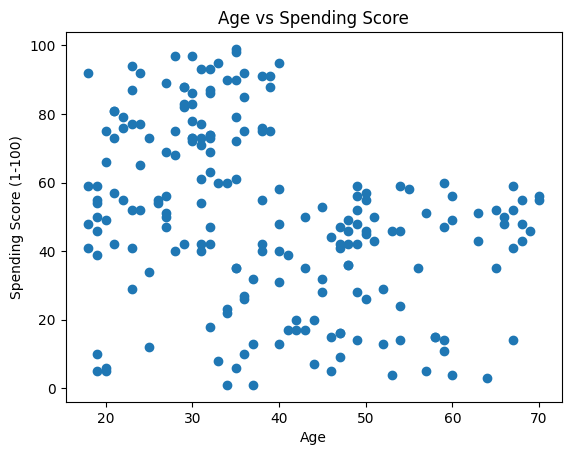

In [51]:
# Scatter plot for Age vs Spending Score
plt.scatter(df['Age'], df['Spending Score (1-100)'])
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.title('Age vs Spending Score')
plt.show()

## K-Means

**Step-by-Step Process of K-Means**

1. **Choose the number of clusters (k)**  
   The first step in the K-Means algorithm is to decide how many clusters, denoted by "k", are needed. This number is provided as input by the user. The value of k dictates how many groupings the data will be divided into.

2. **Initialize centroids randomly**  
   The algorithm randomly selects k points from the dataset or generates k centroids within the range of the data. These centroids serve as the initial centers of the clusters. At the beginning, these centroids are just estimates of where the center of each cluster should be.

3. **Assign each point to the nearest centroid**  
   For each data point, the algorithm calculates its distance to all k centroids. The distance is typically measured using **Euclidean distance** (the straight-line distance between two points). After computing the distances, each data point is assigned to the cluster whose centroid is closest to it. At this stage, all points are grouped based on proximity to the centroids.

4. **Recalculate centroids**  
   Once all data points have been assigned to a cluster, the algorithm updates the centroids. The new centroid for each cluster is calculated as the **mean** (average) of all the data points that belong to that cluster. This step adjusts the centroids to better represent the center of their respective clusters.

5. **Repeat the process**  
   Steps 3 (assigning points to centroids) and 4 (recalculating centroids) are repeated. In each iteration, data points are reassigned to the nearest updated centroid, and the centroids are recalculated based on the new groupings. This iterative process continues until the centroids no longer change significantly between iterations.

6. **Check for convergence**  
   The algorithm checks if the centroids have **converged**, meaning they no longer move or change positions between iterations. If the centroids remain the same, the algorithm stops. Otherwise, it continues to iterate. Convergence usually indicates that the clustering process is complete, and the clusters are stable.

7. **Output final clusters**  
   Once convergence is reached, the final set of centroids and the assignment of data points to clusters are produced as the result. The data is now grouped into k clusters, with each point assigned to the cluster whose centroid is closest to it.


In [52]:
def init_centroids(X, k):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))

    # For each feature, pick random values within the range of that feature's data
    for i in range(n_features):
        min_val = np.min(X[:, i])  # Minimum value in the i-th feature
        max_val = np.max(X[:, i])  # Maximum value in the i-th feature
        centroids[:, i] = np.random.uniform(min_val, max_val, size=k)  # Random values for centroids

    print(f"Initial centroids:\n{centroids}\n")
    return centroids

In [53]:
def closest_point(X, centroids):

    # Calculate distances between each data point and each centroid using Euclidean distance
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    # Get the index of the nearest centroid for each data point
    closest = np.argmin(distances, axis=1)

    # Get the minimum distance (nearest centroid) for each data point
    min_distances = np.min(distances, axis=1)

    print(f"Closest centroid for each point:\n{closest}\n")
    print(f"Distances to closest centroids:\n{min_distances}\n")

    return closest, min_distances

In [54]:
def new_centers(X, labels):
    k = np.unique(labels).size

    # Calculate the new centroids as the mean of points assigned to each centroid
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

    print(f"New centroids after updating:\n{new_centroids}\n")

    return new_centroids

In [55]:
def kmeans(X, k, max_iters=100):
    centroids = init_centroids(X, k)

    # Iterate to update centroids and labels until convergence or max iterations
    for i in range(max_iters):
        print(f"Iteration {i + 1}:\n")

        # Assign each point to the nearest centroid
        labels, _ = closest_point(X, centroids)

        # Recompute the centroids based on the current assignment
        new_centroids = new_centers(X, labels)

        # Check for convergence (if centroids didn't change, stop)
        if np.all(centroids == new_centroids):
            print(f"Centroids have converged at iteration {i + 1}.\n")
            break

        centroids = new_centroids  # Update centroids for the next iteration

    return centroids, labels

## Example with Synthetic 2D Data

In [56]:
np.random.seed(42)

# Generate 3 clusters of random points in 2D
X = np.vstack([
    np.random.randn(100, 2) + [3, 3],   # Cluster 1 centered around [3, 3]
    np.random.randn(100, 2) + [-3, -3], # Cluster 2 centered around [-3, -3]
    np.random.randn(100, 2)             # Cluster 3 centered around [0, 0]
])

In [57]:
X.shape

(300, 2)

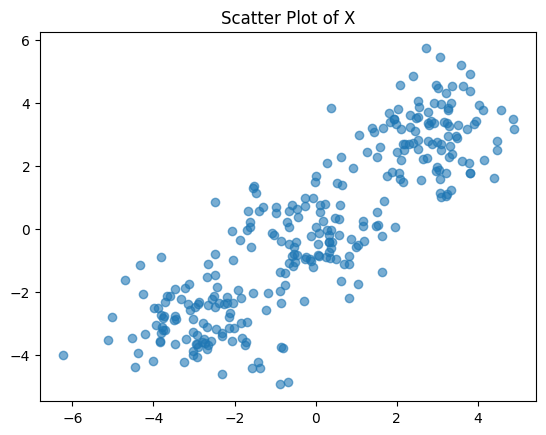

In [58]:
plt.scatter(X[:, 0], X[:, 1], marker='o', alpha=0.6)
plt.title("Scatter Plot of X")
plt.show()

Initial centroids:
[[-3.69028316  1.89040449]
 [ 1.79556434  2.45390832]
 [ 1.77090555  0.84000692]]

Iteration 1:

Closest centroid for each point:
[1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 0 2 0 0 0 0 2 0 2 0 0 0 0 0 2 2 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 0 2 0 0 0 0 0 0 0 2 0 0 0 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 0 2 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2
 2 0 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 0 0 1 2 2 2 0 2 1 2 2 2 2
 2 2 2 2]

Distances to closest centroids:
[1.74935241 2.77698181 1.01919746 3.07799455 1.31351842 0.74536277
 1.49160152 0.5207341  0.88141676 0.813711   2.68922903 1.49057551
 0.93130963 0.92333759 0.65520156 2.47294567 1.29618232 2.13633809
 1.4518

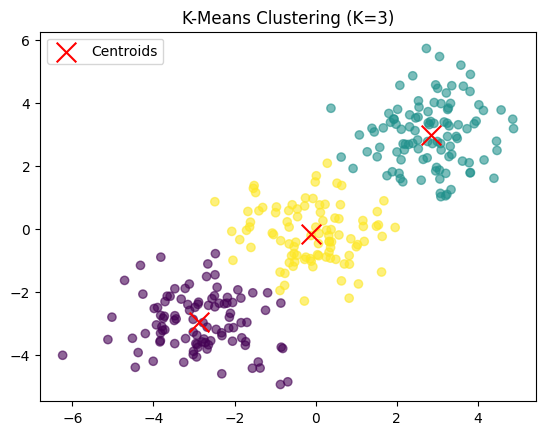

In [59]:
k = 3  # Set number of clusters
centroids, labels = kmeans(X, k)

# Final visualization of K-Means results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("K-Means Clustering (K=3)")
plt.legend()
plt.show()

## K-Means with Real Customer Segmentation Data

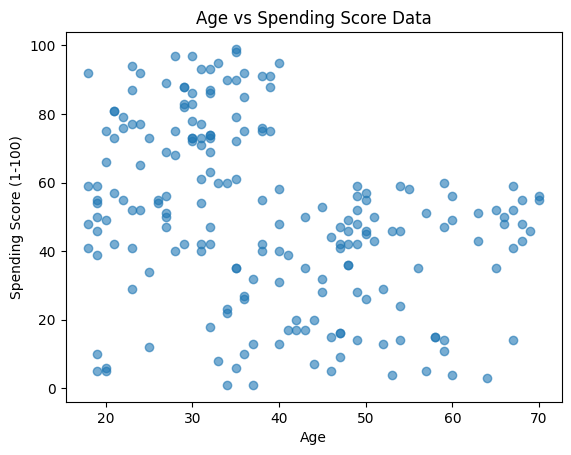

In [60]:
# Use 'Age' and 'Spending Score (1-100)' as features
X = df[['Age', 'Spending Score (1-100)']].values

# Plot the data
plt.scatter(X[:, 0], X[:, 1], marker='o', alpha=0.6)
plt.title("Age vs Spending Score Data")
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

Initial centroids:
[[31.09355106 58.17239589]
 [35.97619166 40.28343884]
 [27.44308127 46.27656876]
 [65.23942919 93.83376728]]

Iteration 1:

Closest centroid for each point:
[2 0 1 0 1 0 1 0 1 0 1 3 1 0 1 0 1 0 1 3 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 0 2 2 1 1 0 0 0 1 1 1 1 2 1 1 2 1 0 1 0 1 1 0 2 1 1 1 1
 1 0 0 1 2 1 1 0 1 1 0 1 0 0 0 1 1 2 1 1 1 2 1 2 1 2 2 1 3 0 0 2 1 1 1 1 1
 2 1 2 2 2 1 0 1 0 0 1 0 3 1 0 1 3 1 0 1 0 2 0 1 0 1 0 1 0 1 3 2 0 1 3 1 0
 1 3 1 3 1 0 1 0 1 0 1 0 1 0 1 3 1 0 1 3 1 0 1 0 1 3 1 0 1 0 1 3 1 0 1 0 1
 3 1 0 1 0 1 0 1 3 1 0 1 0 1 0]

Distances to closest centroids:
[11.14603402 24.95955293 37.82317912 20.49351716  4.98425732 20.01289932
 34.29733414 36.73040682 46.6410618  13.87077826 40.66074079 30.67756571
 33.53058922 20.11957115 27.30264124 22.72623515  5.3728648  13.57712272
 19.59791891 30.52508104  5.3728648  16.03088295 36.67966453 14.82789923
 31.86968504 23.91939953 12.2492643   4.8224152  10.1179677  29.94221648
 43.51587413 17.937

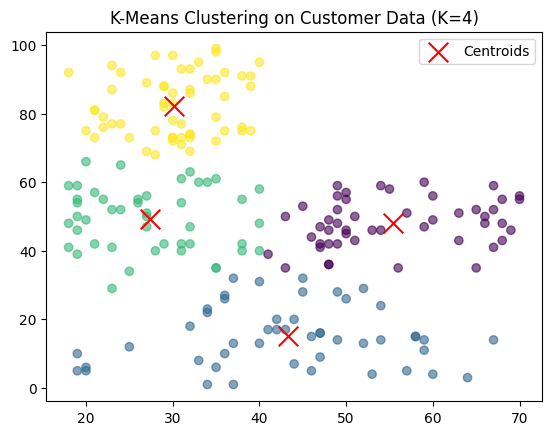

In [61]:
k = 4  # Set number of clusters
centroids, labels = kmeans(X, k)

# Final visualization
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("K-Means Clustering on Customer Data (K=4)")
plt.legend()
plt.show()